In [1]:
%%time
import os

import numpy as np

from PIL import Image
from numpy import asarray
from os import listdir
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

CPU times: user 1.23 s, sys: 121 ms, total: 1.35 s
Wall time: 1.93 s


# 1. Preparation
---
##### Load in images for dataset similar to Lab 2

In [2]:
%%time
#file paths were chosen to have reasonably sized dataset
normal_dir = "chest_xray/train/NORMAL/"
pneumonia_dir = "chest_xray/test/PNEUMONIA/"

data = []
classes = []
h, w = 100, 100

#load normal images
normal_count=0
for images in os.listdir(normal_dir):
    #create image, resize to 100x100
    image = Image.open(normal_dir + images)
    image = image.resize((h,w))
    #convert image to numpy array and flatten
    data_i = asarray(image)
    #feature_i = data_i.flatten()
    #add image to list of images
    data.append(data_i)
    #store as false (not pneumonia)
    classes.append(0)
    normal_count+=1
    
#load pneumonia images
pneumonia_count=0
for images in os.listdir(pneumonia_dir):
    #create image, resize to 100x100
    image = Image.open(pneumonia_dir + images)
    image = image.resize((h,w))
    #convert image to numpy array and flatten
    data_i = asarray(image)
    #feature_i = data_i.flatten()
    #add image to list of images
    data.append(data_i)
    #store as true (pneumonia)
    classes.append(1)
    pneumonia_count+=1
    
data = np.asarray(data)
#normalize pixel data
data = data/255.0-0.5
data = np.expand_dims(data, axis=-1)

print(data.shape)
print(data.shape[0], 'total images')
print('Number of files:', len(classes))
print('Number of normal images:', normal_count, ', Number of pneumonia images:',pneumonia_count)

(1731, 100, 100, 1)
1731 total images
Number of files: 1731
Number of normal images: 1341 , Number of pneumonia images: 390
CPU times: user 26.1 s, sys: 1.06 s, total: 27.1 s
Wall time: 29.7 s


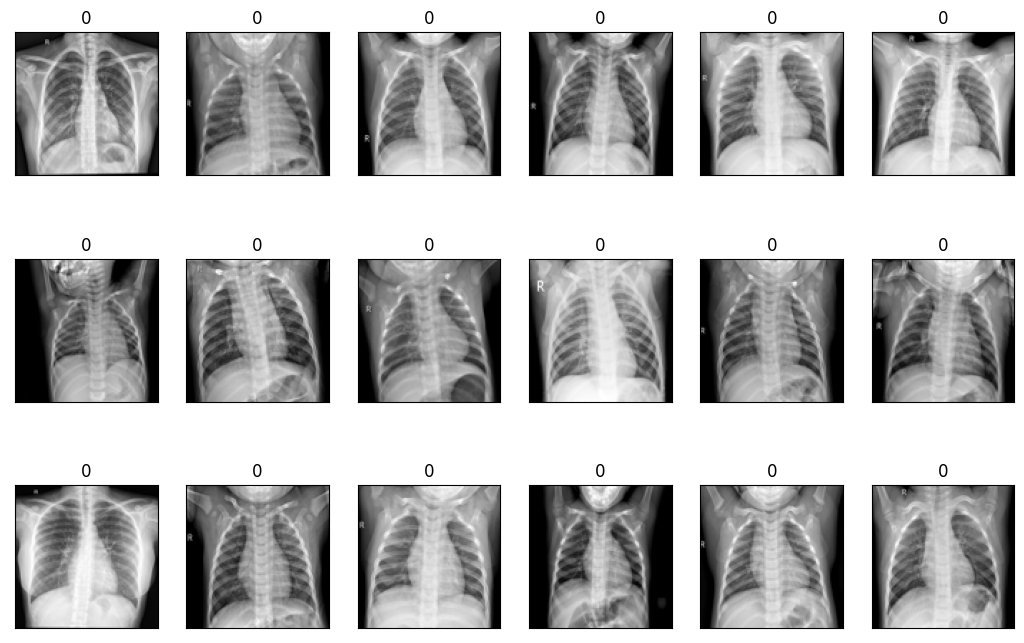

In [3]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(data, classes, 100, 100)

## Evaluation metric
---
##### We chose to use the F1-score metric to account for the false negatives (recall) and false positives (precision) when evaulating our unbalanced unbalanced dataset. In the world of medicine and diagnostics, both false negatives and false positives are extremely important when evaluating a patient. We don't want to wrongly diagnose a patient with pneumonia, and we wouldn't want to wrongly diagnose a patient's lungs as healthy. With the F1-score, we have a better metric to minimize both false ocurrences. Additionally, our dataset is unbalanced in favor of normal lung images. The F1-score suits unbalanced datasets because it is calculated as a harmonic mean of precision and recall.

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K

# F1-score is no longer supported in keras so we must make a F1-score function
# From https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

2022-12-05 14:38:50.707582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Divide data into training and testing
---
##### To divide our data into training and testing, we will use Stratified K-fold cross validation. We chose this method because we need to account for the imbalance of normal images and pneumonia images. A stratified split will create folds with balanced occurences of normal and pneumonia images. Using a K-fold split is beneficial for our small dataset because it will better assist our model with generalization. A K-fold split will help reduce variance and allow the model to fit with each fold.

In [5]:
from sklearn.model_selection import StratifiedKFold

X = data
y = np.asarray(classes)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# 2. Modeling
---
## Data Expansion
---
##### For data augmentation, we are using the keras ImageDataGenerator. We chose this method as a preprocessing technique to shift image heights and widths as well as rotate images. Shifting images can possibly remove unwanted effects of non-uniform image shapes before processing. Including a small rotational adjustment can resemble x-ray images that were not positioned the same as other images but still share a similar orientation. We did not flip images because our dataset images all have similar orientations such as heart position and body structure.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05)

datagen.fit(X)

In [7]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

## Model 1 - Basic CNN

In [32]:
def plot_histories(histories):
    plt.figure(figsize=(20,20))
    for fold_no, history in enumerate(histories):
        keys = list(history.history.keys())
        
        plt.subplot(5,3,3*fold_no+1)
        plt.plot(history.history[keys[0]])
        plt.title('Loss function')
        plt.ylabel('Fold #'+str(fold_no+1))

        plt.subplot(5,3,3*fold_no+2)
        plt.plot(history.history[keys[1]])
        plt.title('Eval Metric')
        plt.ylim(0.5, 1)

In [9]:
def model_1(optimizer, num_filt_layers, l2_lambda):
    reg = l2(l2_lambda)
    cnn = Sequential()
    
    for num_filters in num_filt_layers:
        cnn.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        kernel_initializer='he_uniform', 
                        kernel_regularizer=reg,
                        padding='same',))
        cnn.add( Activation('relu'))
        cnn.add(BatchNormalization())
        cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add one layer on flattened output
    cnn.add( Flatten() )
    
    cnn.add( Dropout(0.25) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=1,
                  activation='sigmoid',
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=reg))

    # Let's train the model 
    cnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[f1])    
    return cnn

In [10]:
def build_model_1(optimizer, num_filt_layers, l2_lambda,
                 
                 batch_size=128, epochs=15, verbose=1):
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = model_1(optimizer, num_filt_layers, l2_lambda)

        print('Fold',fold_no+1)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train)/batch_size),
                              epochs=epochs, verbose=verbose)        
        
        print('')
        scores = []
        scores = cnn.evaluate(X_test, y_test, verbose=verbose)
        print('-' * 110)

        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print("Loss:",round(np.mean(eval_scores[:,0]), 5))
    print("F1:",round(np.mean(eval_scores[:,1]), 5))
    
    return histories, eval_scores, cnn

In [11]:
%%time
# Using Adam optimizer and tuning hyper parameters like in the last lab
# Adding batch normalization to speed things up
# he_uniform initializing for relu and glorot_uniform initializing for sigmoid
#------------------------------------------------------------#
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001, epsilon=1e-8)
#------------------------------------------------------------#

l2_lambda = 0.0001; num_filt_layers = [32,64]

histories_1a, eval_scores_1a, cnn_1a = build_model_1(optimizer=adam, num_filt_layers=num_filt_layers, l2_lambda=l2_lambda)

2022-12-05 14:38:58.912713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fold 1

Epoch 1/15
10/10 [==============================] - 9s 820ms/step - loss: 5.1273 - f1: 0.3690
Epoch 2/15
10/10 [==============================] - 8s 812ms/step - loss: 0.4407 - f1: 0.7799
Epoch 3/15
10/10 [==============================] - 8s 816ms/step - loss: 0.2771 - f1: 0.8446
Epoch 4/15
10/10 [==============================] - 8s 812ms/step - loss: 0.2004 - f1: 0.8639
Epoch 5/15
10/10 [==============================] - 8s 811ms/step - loss: 0.2061 - f1: 0.8744
Epoch 6/15
10/10 [==============================] - 8s 816ms/step - loss: 0.1795 - f1: 0.9097
Epoch 7/15
10/10 [==============================] - 8s 762ms/step - loss: 0.1510 - f1: 0.9199
Epoch 8/15
10/10 [==============================] - 8s 835ms/step - loss: 0.1604 - f1: 0.9364
Epoch 9/15
10/10 [==============================] - 9s 872ms/step - loss: 0.1418 - f1: 0.9246
Epoch 10/15
10/10 [==============================] - 9s 842ms/step - loss: 0.1377 - f1: 0.9169
Epoch 11/15
10/10 [==============================] 

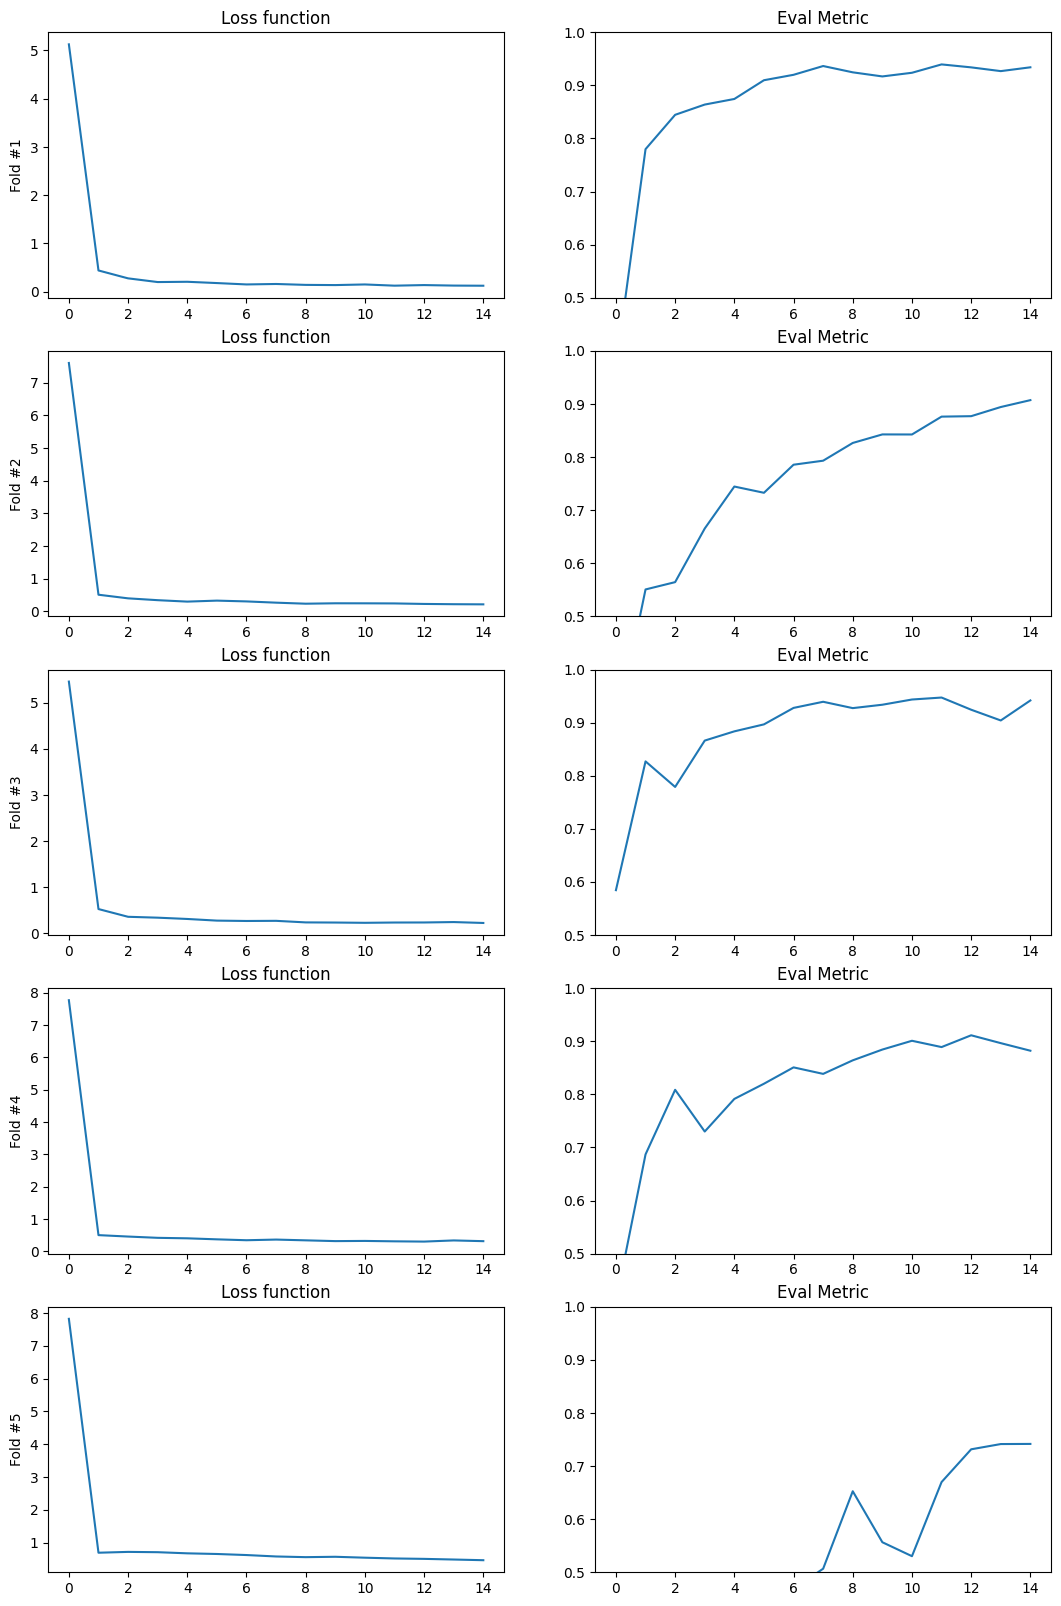

In [33]:
plot_histories(histories_1a)

In [16]:
%%time
# Now lets double the number of conv/pool layers

num_filt_layers = [32,32,64,64]

histories_1b, eval_scores_1b, cnn_1b = build_model_1(optimizer=adam, num_filt_layers=num_filt_layers, l2_lambda=l2_lambda)

Fold 1

Epoch 1/15
10/10 [==============================] - 9s 812ms/step - loss: 0.9460 - f1: 0.5956
Epoch 2/15
10/10 [==============================] - 8s 803ms/step - loss: 0.2510 - f1: 0.8647
Epoch 3/15
10/10 [==============================] - 8s 813ms/step - loss: 0.2001 - f1: 0.9024
Epoch 4/15
10/10 [==============================] - 8s 782ms/step - loss: 0.1735 - f1: 0.9404
Epoch 5/15
10/10 [==============================] - 8s 788ms/step - loss: 0.1585 - f1: 0.9370
Epoch 6/15
10/10 [==============================] - 8s 785ms/step - loss: 0.1584 - f1: 0.9254
Epoch 7/15
10/10 [==============================] - 8s 782ms/step - loss: 0.1619 - f1: 0.9367
Epoch 8/15
10/10 [==============================] - 8s 786ms/step - loss: 0.1348 - f1: 0.9502
Epoch 9/15
10/10 [==============================] - 8s 784ms/step - loss: 0.1262 - f1: 0.9620
Epoch 10/15
10/10 [==============================] - 8s 784ms/step - loss: 0.1068 - f1: 0.9736
Epoch 11/15
10/10 [==============================] 

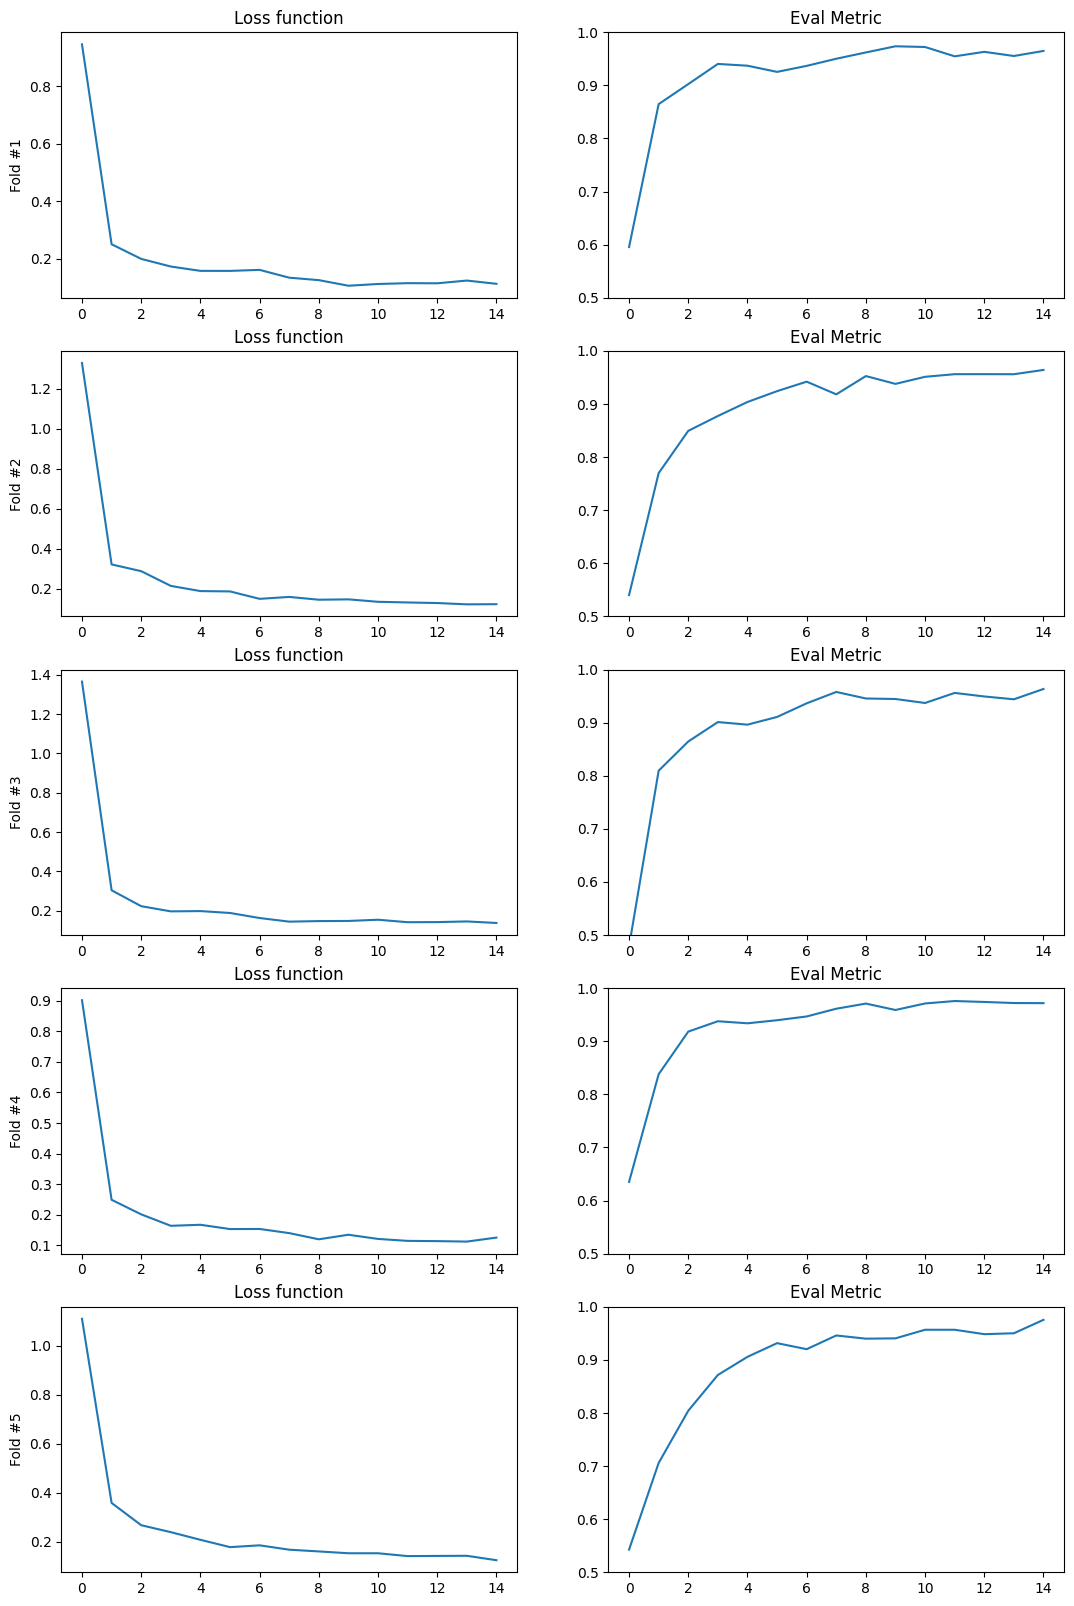

In [26]:
plot_histories(histories_1b)

---
##### By doubling the number of layers, but keeping the same number of filters, our new model variant performs considerably better insofar that we see convergence for each fold and our evaluation metric is comparatively higher for each iteration. Also, run time appears to remain the same. 
---

## Model 2: Alexnet Architecture (changing activation of last layer)

In [19]:
def model_2(optimizer, num_filt_layers, l2_lambda):
    reg = l2(l2_lambda)
    cnn = Sequential()
    
    # Conv 1 - Max Pool 1
    cnn.add( Conv2D(filters=num_filt_layers[0], 
                    kernel_size=(11,11),
                    kernel_initializer='he_uniform', 
                    kernel_regularizer=reg,
                    strides=4,
                    padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    
    # Conv 2 - Max Pool 2
    cnn.add( Conv2D(filters=num_filt_layers[1], 
                kernel_size=(5,5),
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    
    # Conv3 - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[2], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    
    # Conv4 - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[3], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    
    # Conv5 - Max Pool 3 - Dropout 1
    cnn.add( Conv2D(filters=num_filt_layers[4], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    cnn.add(Dropout(0.5))


    # Full, connected layers
    cnn.add( Flatten() )
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    cnn.add(Dense(units=1,
                  activation='sigmoid', # using sigmoid activation for binary classification instead of softmax
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=reg))
    
    # Let's train the model 
    cnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[f1])    
    return cnn

In [21]:
def build_model_2(optimizer, l2_lambda,
                  
                  num_filt_layers=[96, 256, 384, 384, 256], # original Alexnet filter params
                  
                  batch_size=128, epochs=15, verbose=1
                 ):
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = model_2(optimizer, num_filt_layers, l2_lambda)

        print('Fold',fold_no+1)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train)/batch_size),
                              epochs=epochs, verbose=verbose)        
        
        print('')
        scores = []
        scores = cnn.evaluate(X_test, y_test, verbose=verbose)
        print('-' * 110)

        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print("Loss:",round(np.mean(eval_scores[:,0]), 5))
    print("F1:",round(np.mean(eval_scores[:,1]), 5))
    
    return histories, eval_scores, cnn

In [34]:
%%time
# Needed to increase epochs because it wasn't converging
histories_2a, eval_scores_2a, cnn_2a = build_model_2(optimizer=adam, l2_lambda=l2_lambda, epochs=20)

Fold 1

Epoch 1/20
10/10 [==============================] - 8s 673ms/step - loss: 1.6690 - f1: 0.4185
Epoch 2/20
10/10 [==============================] - 7s 661ms/step - loss: 0.9284 - f1: 0.6707
Epoch 3/20
10/10 [==============================] - 7s 725ms/step - loss: 0.8179 - f1: 0.8164
Epoch 4/20
10/10 [==============================] - 7s 732ms/step - loss: 0.8327 - f1: 0.8644
Epoch 5/20
10/10 [==============================] - 7s 686ms/step - loss: 0.7543 - f1: 0.9345
Epoch 6/20
10/10 [==============================] - 7s 650ms/step - loss: 0.7342 - f1: 0.9516
Epoch 7/20
10/10 [==============================] - 7s 650ms/step - loss: 0.7710 - f1: 0.9303
Epoch 8/20
10/10 [==============================] - 7s 666ms/step - loss: 0.7650 - f1: 0.9192
Epoch 9/20
10/10 [==============================] - 7s 727ms/step - loss: 0.7511 - f1: 0.9334
Epoch 10/20
10/10 [==============================] - 7s 719ms/step - loss: 0.7226 - f1: 0.9464
Epoch 11/20
10/10 [==============================] 

11/11 [==============================] - 1s 36ms/step - loss: 2.3428 - f1: 0.2609
--------------------------------------------------------------------------------------------------------------
Fold 5

Epoch 1/20
10/10 [==============================] - 8s 685ms/step - loss: 1.7567 - f1: 0.4721
Epoch 2/20
10/10 [==============================] - 7s 671ms/step - loss: 0.9232 - f1: 0.6854
Epoch 3/20
10/10 [==============================] - 7s 650ms/step - loss: 0.9136 - f1: 0.7626
Epoch 4/20
10/10 [==============================] - 7s 686ms/step - loss: 0.8891 - f1: 0.8435
Epoch 5/20
10/10 [==============================] - 7s 663ms/step - loss: 0.8384 - f1: 0.8810
Epoch 6/20
10/10 [==============================] - 7s 679ms/step - loss: 0.8452 - f1: 0.8862
Epoch 7/20
10/10 [==============================] - 7s 652ms/step - loss: 0.8457 - f1: 0.8838
Epoch 8/20
10/10 [==============================] - 7s 660ms/step - loss: 0.8141 - f1: 0.8994
Epoch 9/20
10/10 [=============================

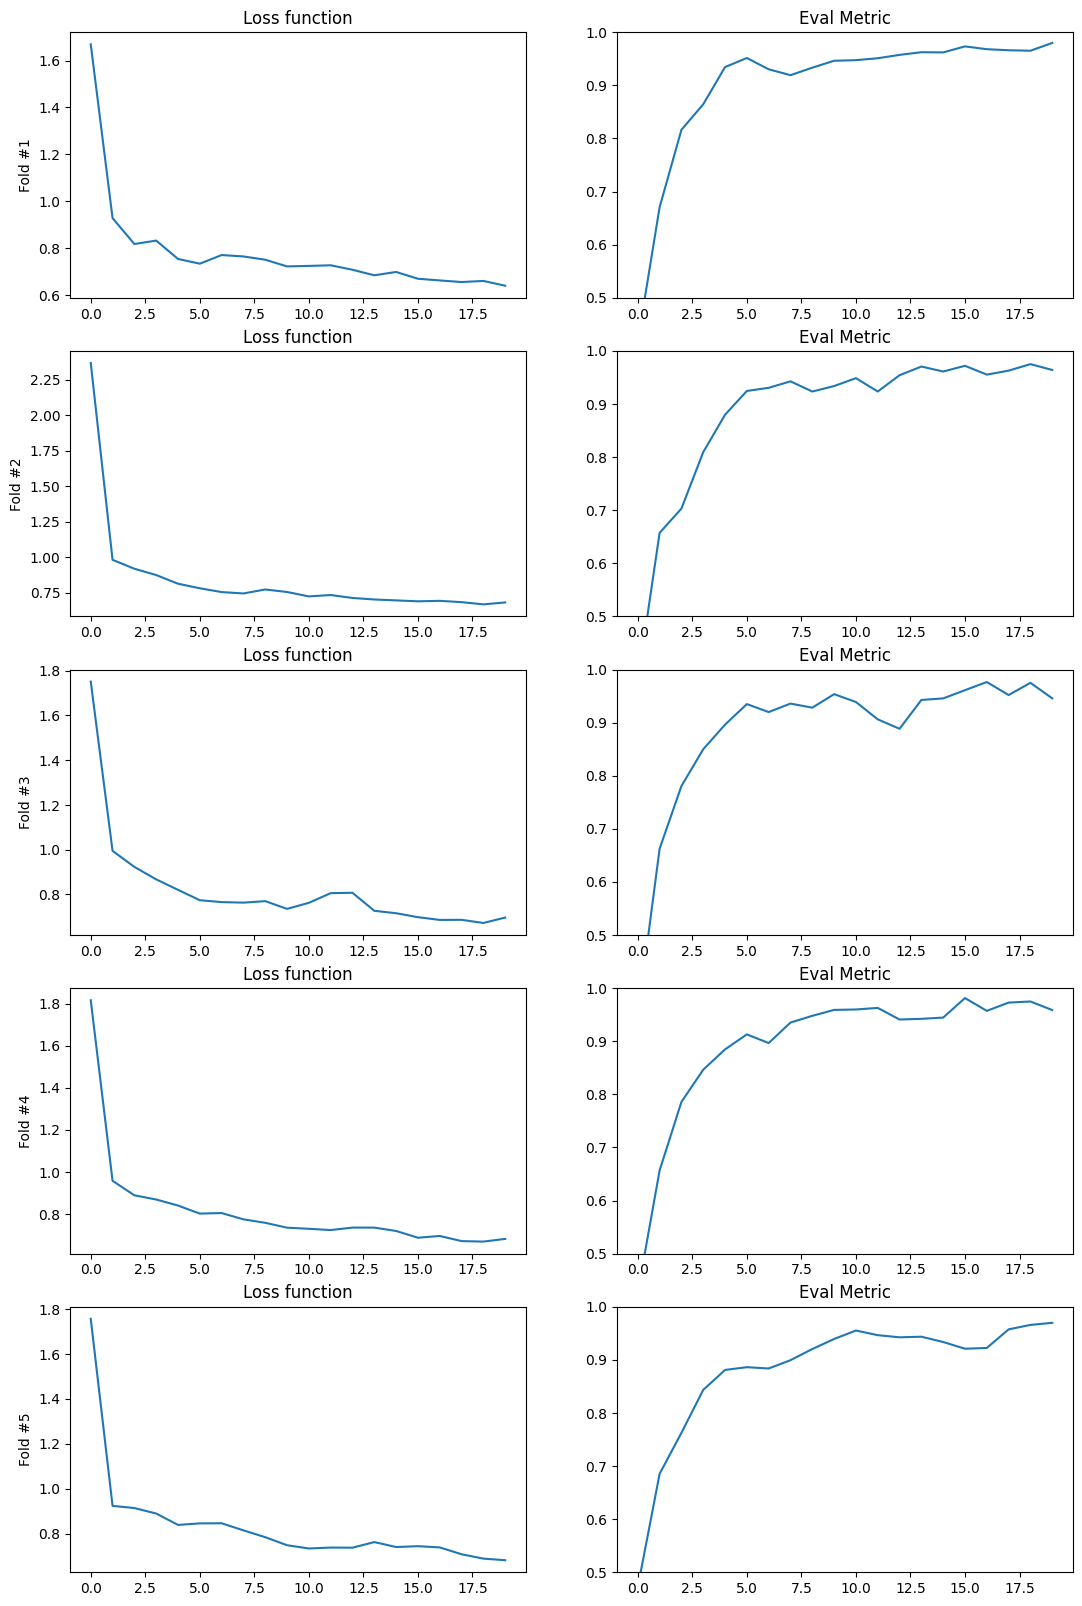

In [92]:
plot_histories(histories_2a)

---
##### Alexnet doesn't perform much greater than our basic cnn (doing just a visual test). Moreover, it actually appears that Alexnet may take a little longer to converge. The eval metrics for both models are comparable, no striking differences. We believe that this is the case because Alexnet was truly optimized for multi-class classification problems, not the simple binary classifier we are attempting to resolve. Nevertheless, let's try to further optimize this model by speeding things up through the utilization of a technique introduced in Inception. We are going to split Alexnet's conv layer 4 into conv layer 4a and conv layer 4b. We will first operate with a (3,1) kernel for 4a then a (1,3) kernel in 4b. This is essentially the same as applying just a single (3,3) kernel in one layer, but should speed up the processing.
---

In [88]:
def model_2_alt(optimizer, num_filt_layers, l2_lambda):
    reg = l2(l2_lambda)
    cnn = Sequential()
    
    # Conv 1 - Max Pool 1
    cnn.add( Conv2D(filters=num_filt_layers[0], 
                    kernel_size=(11,11),
                    kernel_initializer='he_uniform', 
                    kernel_regularizer=reg,
                    strides=4,
                    padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    
    # Conv 2 - Max Pool 2
    cnn.add( Conv2D(filters=num_filt_layers[1], 
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    
    # Conv3 - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[2], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
#--------------------------------------------------------------------------------------------------#  
    # Let's speed things up
    # (3,3) is the same as first doing a (1,3) then a (3,1) - based on the work done on Inception
    # Conv4a - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[3], 
                kernel_size=(1,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())

    # Conv4b - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[3], 
                kernel_size=(3,1), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    # Finish speed up process
#--------------------------------------------------------------------------------------------------#     
    # Conv5 - Max Pool 3 - Dropout 1
    cnn.add( Conv2D(filters=num_filt_layers[4], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    cnn.add(Dropout(0.5))


    # Full, connected layers
    cnn.add( Flatten() )
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    cnn.add(Dense(units=1,
                  activation='sigmoid', # using sigmoid activation for binary classification instead of softmax
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=reg))
    
    # Let's train the model 
    cnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[f1])    
    return cnn

In [90]:
def build_model_2_alt(optimizer, l2_lambda,
                  
                  num_filt_layers=[96, 256, 384, 384, 256], # original Alexnet filter params
                  
                  batch_size=128, epochs=15, verbose=1
                 ):
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = model_2_alt(optimizer, num_filt_layers, l2_lambda)

        print('Fold',fold_no+1)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train)/batch_size),
                              epochs=epochs, verbose=verbose)        
        
        print('')
        scores = []
        scores = cnn.evaluate(X_test, y_test, verbose=verbose)
        print('-' * 110)

        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print("Loss:",round(np.mean(eval_scores[:,0]), 5))
    print("F1:",round(np.mean(eval_scores[:,1]), 5))
    
    return histories, eval_scores, cnn

In [91]:
histories_2b, eval_scores_2b, cnn_2b = build_model_2_alt(optimizer=adam, l2_lambda=l2_lambda, epochs=20)

Fold 1

Epoch 1/20
10/10 [==============================] - 6s 504ms/step - loss: 2.3107 - f1: 0.3818
Epoch 2/20
10/10 [==============================] - 5s 496ms/step - loss: 0.9876 - f1: 0.6239
Epoch 3/20
10/10 [==============================] - 5s 491ms/step - loss: 0.9245 - f1: 0.7932
Epoch 4/20
10/10 [==============================] - 5s 512ms/step - loss: 0.8491 - f1: 0.8658
Epoch 5/20
10/10 [==============================] - 5s 515ms/step - loss: 0.8232 - f1: 0.9188
Epoch 6/20
10/10 [==============================] - 5s 517ms/step - loss: 0.8224 - f1: 0.9120
Epoch 7/20
10/10 [==============================] - 5s 506ms/step - loss: 0.7957 - f1: 0.9361
Epoch 8/20
10/10 [==============================] - 5s 509ms/step - loss: 0.7741 - f1: 0.9447
Epoch 9/20
10/10 [==============================] - 5s 490ms/step - loss: 0.7802 - f1: 0.9308
Epoch 10/20
10/10 [==============================] - 5s 497ms/step - loss: 0.7659 - f1: 0.9457
Epoch 11/20
10/10 [==============================] 

11/11 [==============================] - 1s 30ms/step - loss: 4.7215 - f1: 0.2531
--------------------------------------------------------------------------------------------------------------
Fold 5

Epoch 1/20
10/10 [==============================] - 6s 508ms/step - loss: 2.3826 - f1: 0.3207
Epoch 2/20
10/10 [==============================] - 5s 520ms/step - loss: 1.0064 - f1: 0.5628
Epoch 3/20
10/10 [==============================] - 5s 499ms/step - loss: 0.9474 - f1: 0.7226
Epoch 4/20
10/10 [==============================] - 5s 491ms/step - loss: 0.8685 - f1: 0.8769
Epoch 5/20
10/10 [==============================] - 5s 494ms/step - loss: 0.8619 - f1: 0.8710
Epoch 6/20
10/10 [==============================] - 5s 483ms/step - loss: 0.8266 - f1: 0.8789
Epoch 7/20
10/10 [==============================] - 5s 506ms/step - loss: 0.8268 - f1: 0.8959
Epoch 8/20
10/10 [==============================] - 5s 503ms/step - loss: 0.7779 - f1: 0.9248
Epoch 9/20
10/10 [=============================

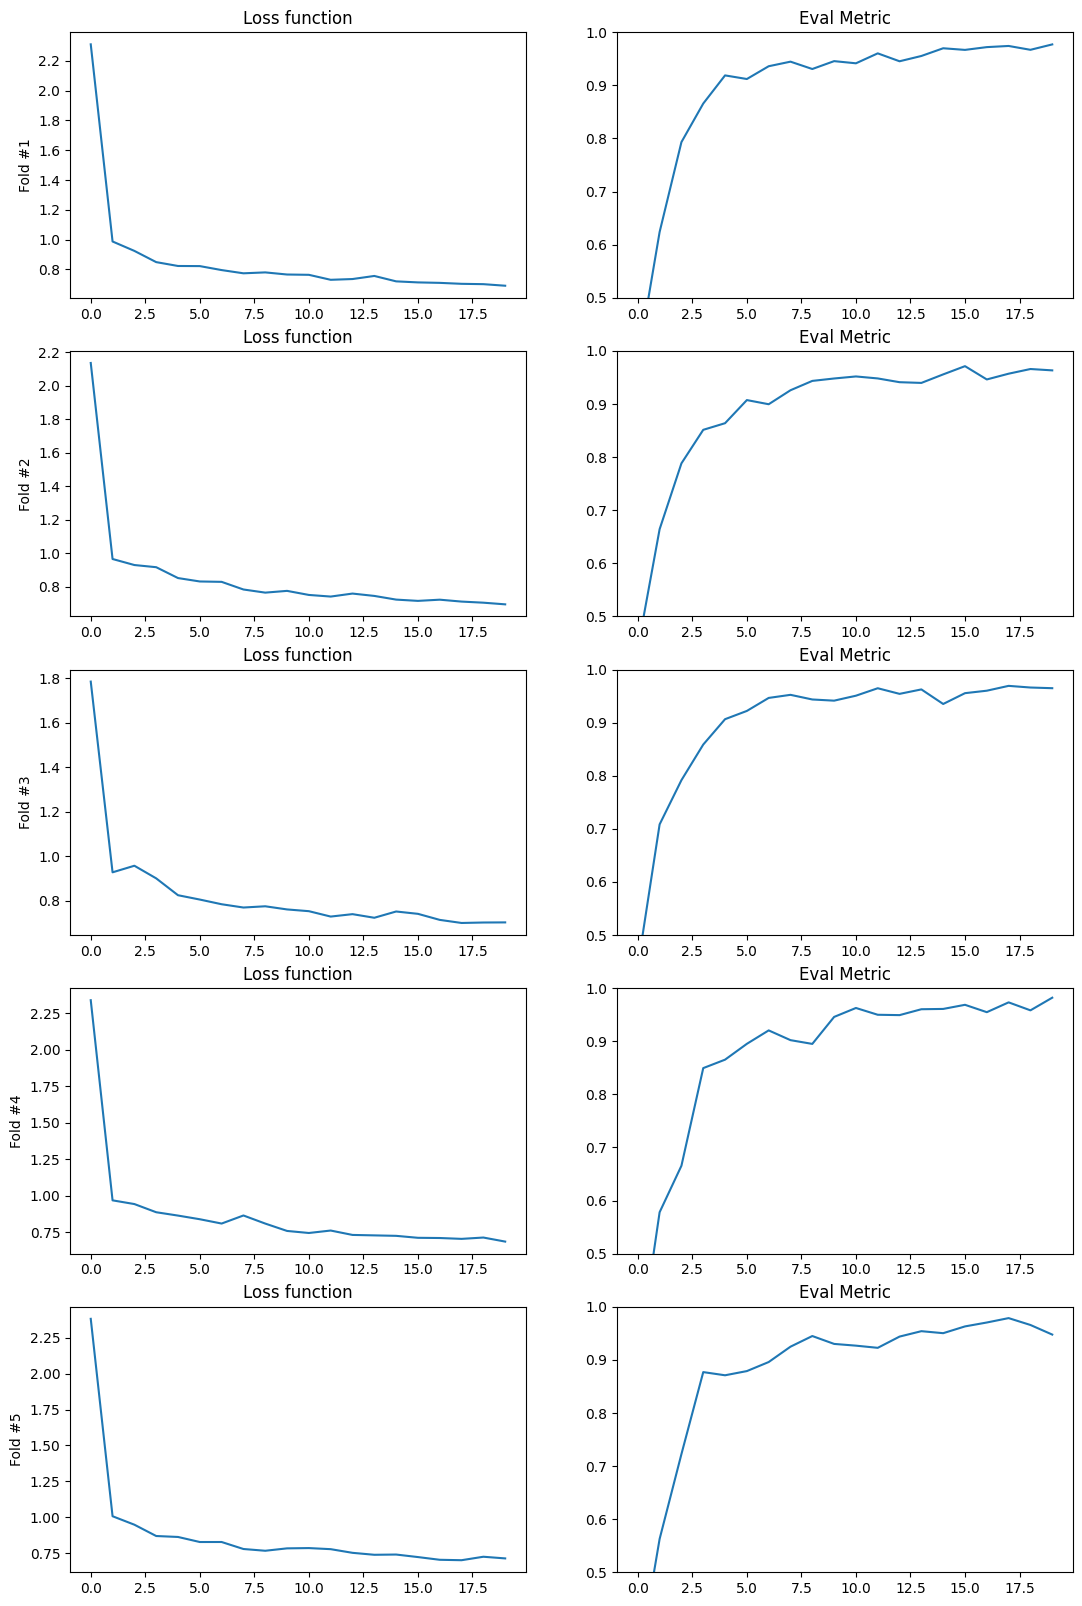

In [93]:
plot_histories(histories_2b)

---
##### It looks like we sped up the processing while reducing the time it took for the model to converge. Eval metrics remain similar. As a note, my computer runs the slowest out of our group. Other group members see results twice as fast for each of the models. All in all, our models look good based on the f1 scores we get per epoch within each fold (almost every fold within each model converges well above 0.9).
---

## Visualizing CNN Results

In [100]:
# Let's begin by summarizing each of our models
cnn_1a.summary() # basic cnn

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, None, None, 32)    320       
                                                                 
 activation_8 (Activation)   (None, None, None, 32)    0         
                                                                 
 batch_normalization_8 (Batc  (None, None, None, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 activation_9 (Activation)   (None, None, None, 64)   

In [101]:
cnn_1b.summary() # basic cnn -- now doubled conv/pool layers

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, None, None, 32)    320       
                                                                 
 activation_26 (Activation)  (None, None, None, 32)    0         
                                                                 
 batch_normalization_26 (Bat  (None, None, None, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, None, None, 32)    9248      
                                                                 
 activation_27 (Activation)  (None, None, None, 32)   

In [102]:
cnn_2a.summary() # Alexnet

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, None, None, 96)    11712     
                                                                 
 activation_75 (Activation)  (None, None, None, 96)    0         
                                                                 
 batch_normalization_75 (Bat  (None, None, None, 96)   384       
 chNormalization)                                                
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, None, None, 96)   0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, None, None, 256)   614656    
                                                                 
 activation_76 (Activation)  (None, None, None, 256) 

In [103]:
cnn_2b.summary() # Alexnet -- sped up by Inception

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_198 (Conv2D)         (None, None, None, 96)    11712     
                                                                 
 activation_182 (Activation)  (None, None, None, 96)   0         
                                                                 
 batch_normalization_136 (Ba  (None, None, None, 96)   384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_119 (MaxPooli  (None, None, None, 96)   0         
 ng2D)                                                           
                                                                 
 conv2d_199 (Conv2D)         (None, None, None, 256)   221440    
                                                                 
 activation_183 (Activation)  (None, None, None, 256)

In [120]:
# Next let's take a look at the average scores for each fold within each model
all_histories = [histories_1a, histories_1b, histories_2a, histories_2b]
scores = []
for model_histories in all_histories:
    score_i = []
    for fold_no, history in enumerate(model_histories):
        keys = list(history.history.keys())  
        score_i.append(np.mean(history.history[keys[1]]))
    scores.append(score_i)
scores = np.array(scores)
for i in range(len(scores)):
    print('Model ' + str(i+1) + ' average score per fold is: ' + str(scores[i,:]))

Model 1 average score per fold is: [0.8664861  0.74577489 0.8817094  0.81091303 0.4995981 ]
Model 2 average score per fold is: [0.91989299 0.89329501 0.89291548 0.9269644  0.88634683]
Model 3 average score per fold is: [0.9009398  0.88352865 0.88209653 0.89236644 0.88158043]
Model 4 average score per fold is: [0.89412258 0.8886151  0.89976907 0.87167045 0.87256624]


In [121]:
cnn_1a_scores = scores[0,:]; cnn_1b_scores = scores[1,:]; cnn_2a_scores = scores[2,:]; cnn_2b_scores = scores[3,:]

# Exceptional Work